## 1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,ShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, classification_report, roc_auc_score,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier,Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
plt.rc('figure',figsize=(9,5))

## 2. Предобработка данных и первичный анализ

In [2]:
data = pd.read_csv('/Users/kostyabykov/Downloads/BankChurners.csv')

In [3]:
drop_columns = ['CLIENTNUM',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
data = data.drop(drop_columns,errors='ignore',axis=1)

print(data.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [4]:
cat_types = ['bool','object','category']
data = data.copy()
data[data.select_dtypes(cat_types).columns] = data.select_dtypes(cat_types).apply(lambda x: x.astype('category'))

In [5]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [6]:
# Рассмотрим данные внутри каждого категориального столбца
cat_col = ['Attrition_Flag', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Total_Relationship_Count']
for column in data[cat_col].columns:
    print("Столбец:", column)
    print(data[column].value_counts())
    print('\n')

Столбец: Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64


Столбец: Gender
F    5358
M    4769
Name: Gender, dtype: int64


Столбец: Dependent_count
3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64


Столбец: Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64


Столбец: Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64


Столбец: Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64


Столбец: Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


Столбец: Total_Relationsh

In [7]:
print("Кол-во дубликатов:", data.duplicated().sum())
print('Кол-во пропусков:', data.isnull().sum().sum())

Кол-во дубликатов: 0
Кол-во пропусков: 0


In [8]:
# Пометить ушедших клиентов как 1, текущих клиентов как 0
data['Attrition_Flag'] = data['Attrition_Flag'].apply(lambda x: 0 if x == 'Existing Customer' else 1)

#### Вывод
На этапе предобработки данных можно сделать следующие выводы:
- в данных отсутствуют пропуски;
- типы столбцов корректны;
- дубликаты отсутствуют.

## Исследование данных

In [9]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().sum()
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y+10), size = 12)


In [10]:
data['Dependent_count'].value_counts().count()

6

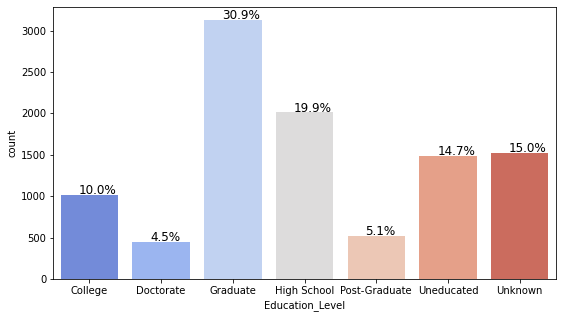

In [11]:
ax = sns.countplot(x='Education_Level', data=data,palette='coolwarm')

with_hue(ax, data['Education_Level'], 1,data['Education_Level'].value_counts().count())

In [12]:
data.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [13]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [14]:
# Разделим столбцы на 3 категории: бинарные(0 или 1), категориальные, числовые для удобного построения графиков

binary_features = data[['Gender','Attrition_Flag']]
features_triple = data[['Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 
                         'Total_Relationship_Count', 'Months_on_book',
                        'Months_Inactive_12_mon','Contacts_Count_12_mon', 'Attrition_Flag']]
features_num = data[['Months_on_book',
        'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Attrition_Flag']]


binary_features_1 = binary_features[binary_features['Attrition_Flag']==1]
binary_features_0 = binary_features[binary_features['Attrition_Flag'] == 0]

features_triple_1 = features_triple[features_triple['Attrition_Flag']==1]
features_triple_0 = features_triple[features_triple['Attrition_Flag'] == 0]

features_num_1 = features_num[features_num['Attrition_Flag']==1]
features_num_0 = features_num[features_num['Attrition_Flag']==0]


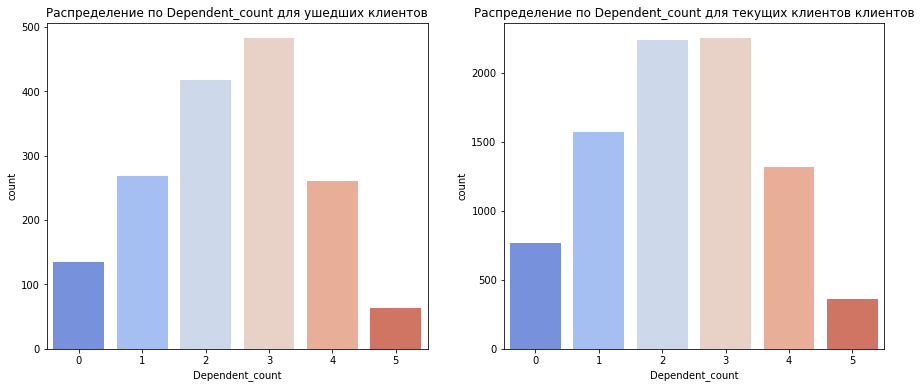

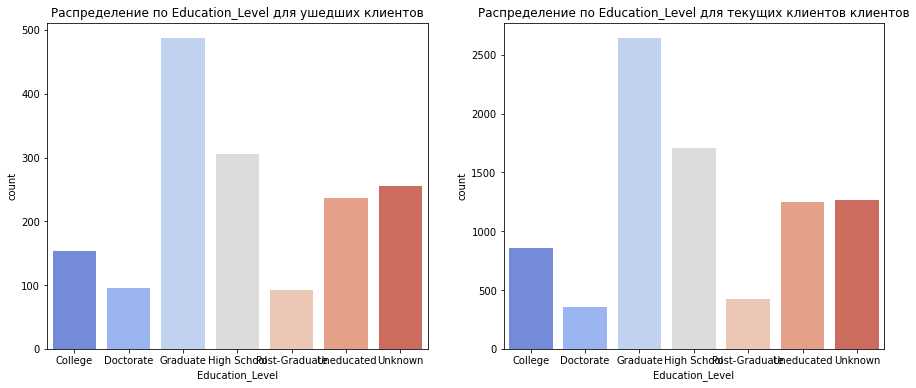

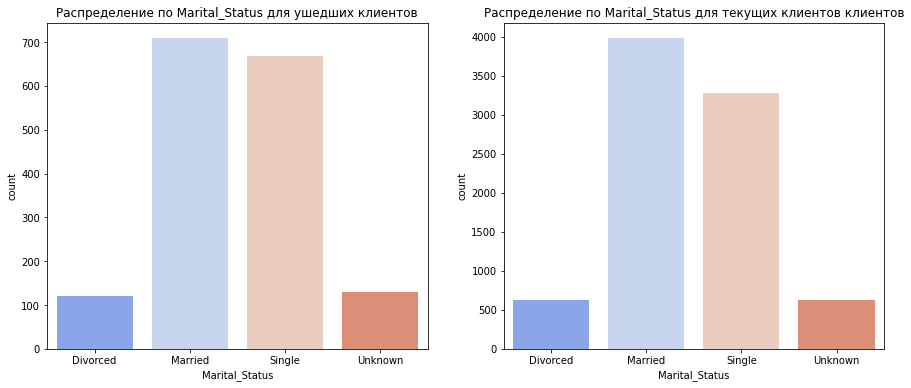

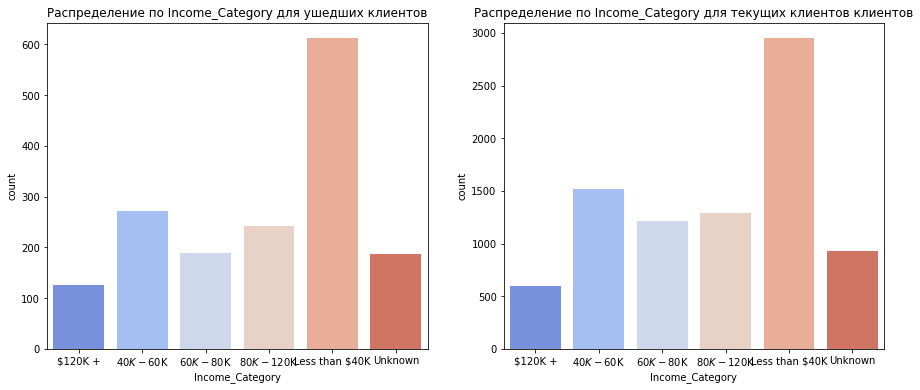

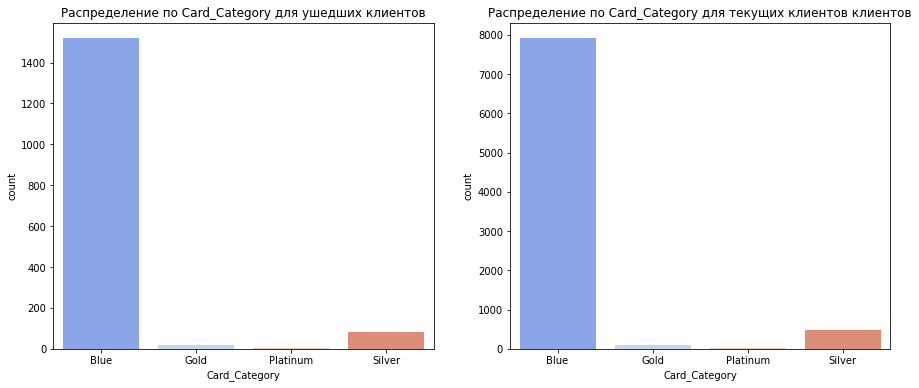

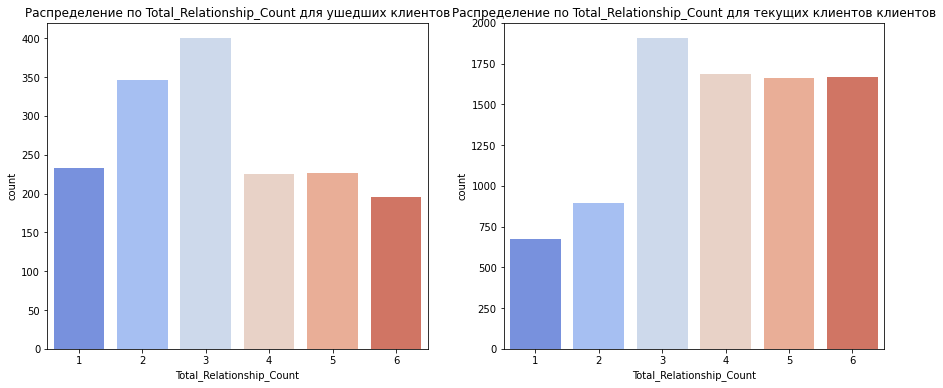

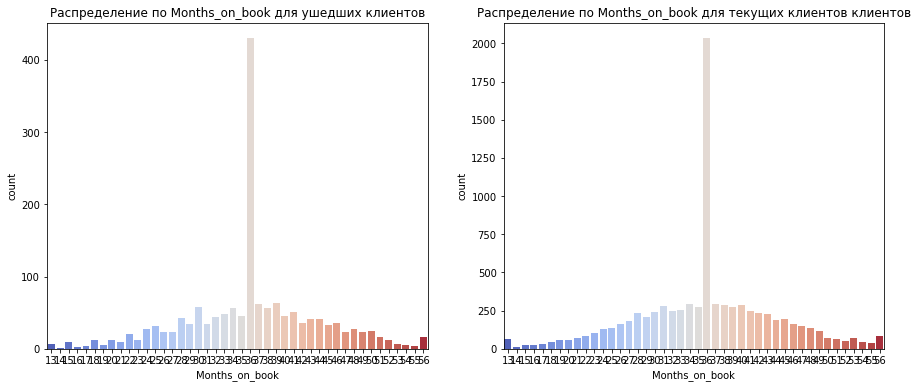

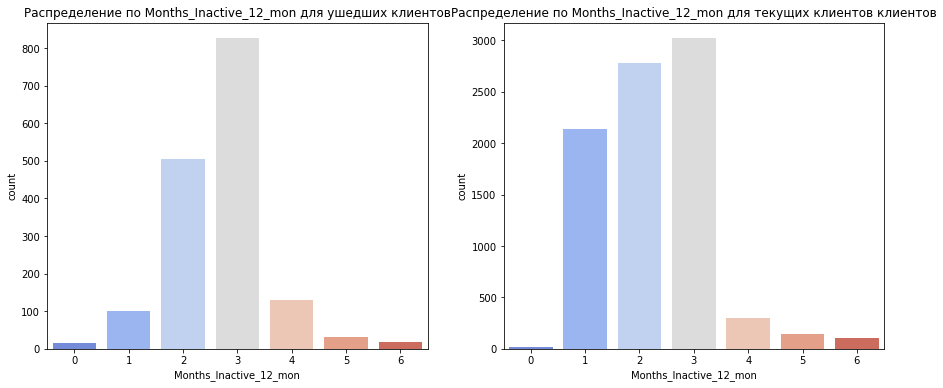

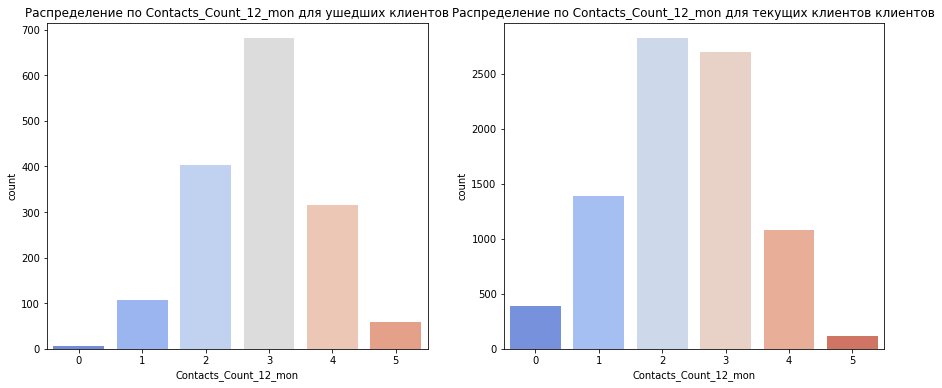

In [15]:
# Построим распределение для категориальных категорий
for column in ['Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 
               'Total_Relationship_Count', 'Months_on_book', 
               'Months_Inactive_12_mon','Contacts_Count_12_mon']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))
    sns.countplot(x=column, data=features_triple[features_triple['Attrition_Flag']==1], ax=axes[0],palette='coolwarm')
    axes[0].set_title('Распределение по ' + column + ' для ушедших клиентов')
    sns.countplot(x=column, data=features_triple[features_triple['Attrition_Flag']==0], ax=axes[1],palette='coolwarm')
    axes[1].set_title('Распределение по ' + column + ' для текущих клиентов клиентов')
    plt.show()

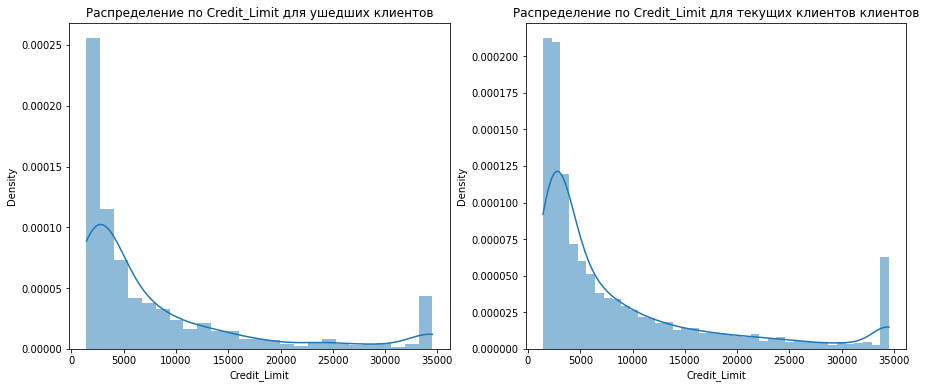

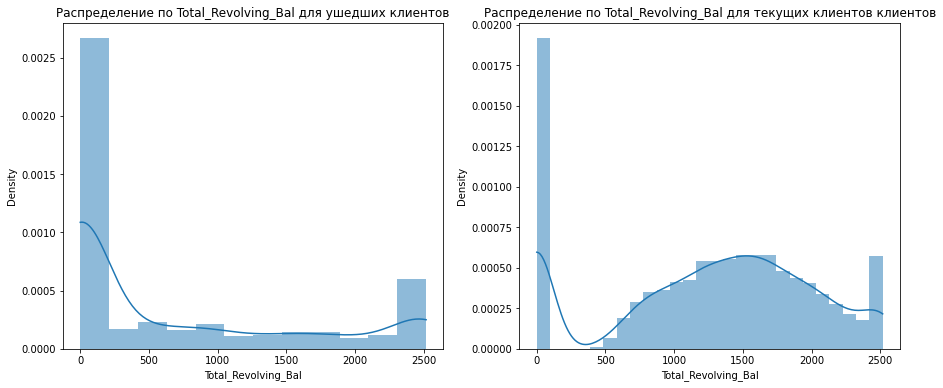

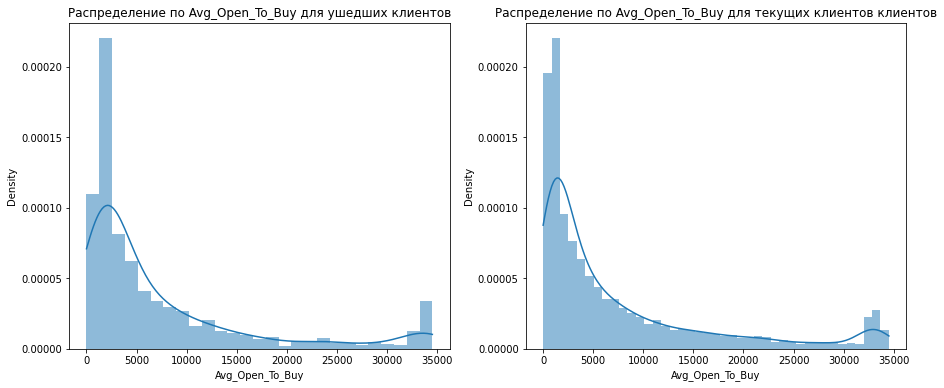

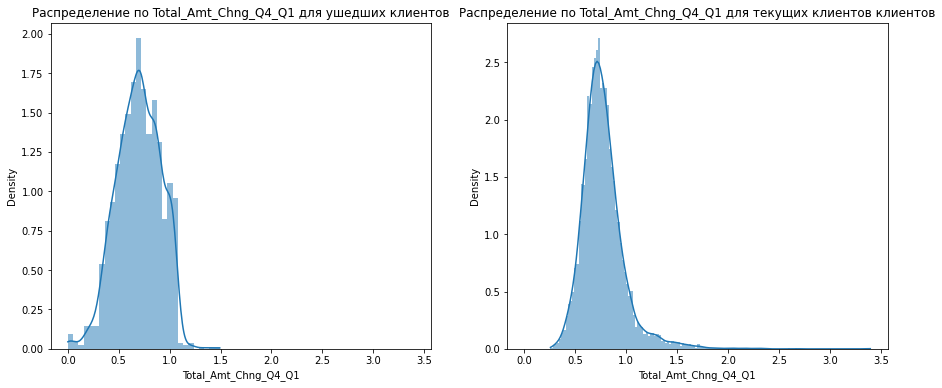

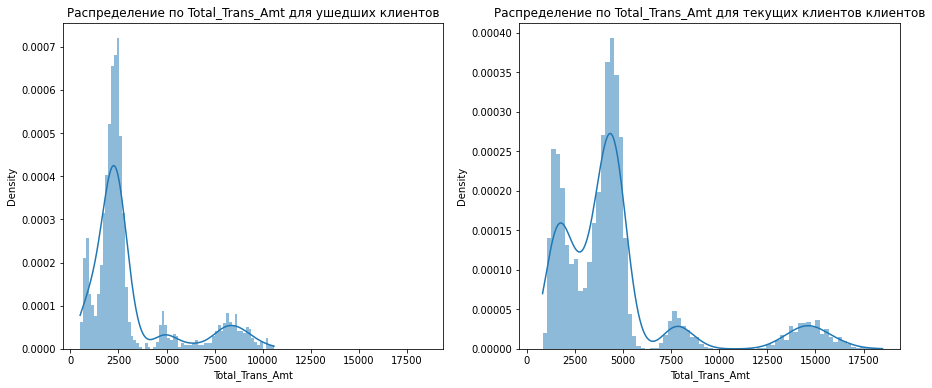

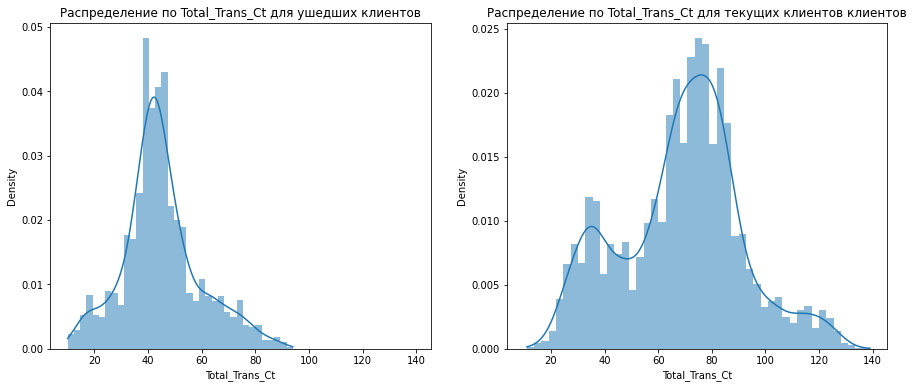

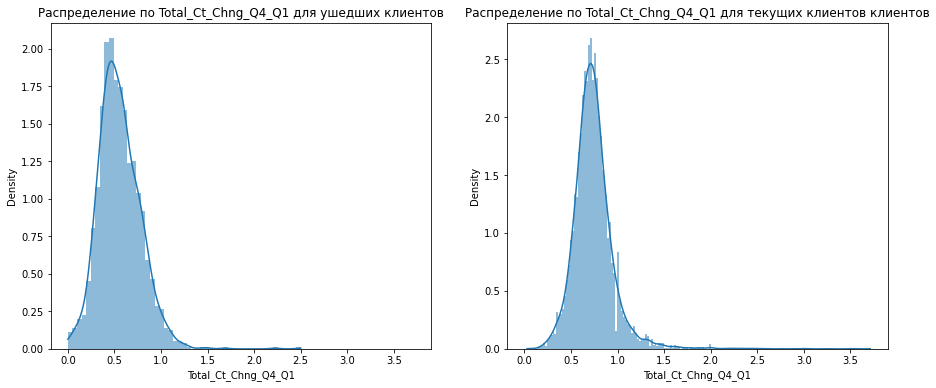

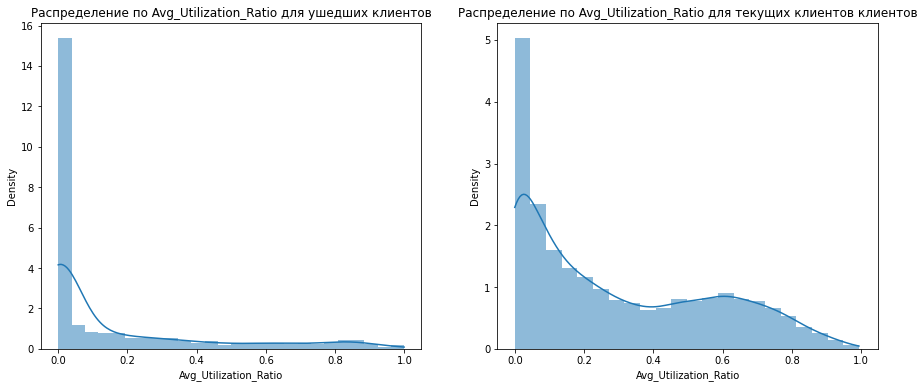

In [16]:
# Пострим расапределение для числовых категорий
for column in ['Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))
    sns.histplot(features_num_1[column], ax=axes[0],kde=True, stat="density", linewidth=0)
    axes[0].set_title('Распределение по ' + column + ' для ушедших клиентов')
    sns.histplot(features_num_0[column], ax=axes[1],kde=True, stat="density", linewidth=0)
    axes[1].set_title('Распределение по ' + column + ' для текущих клиентов клиентов')
    plt.show()

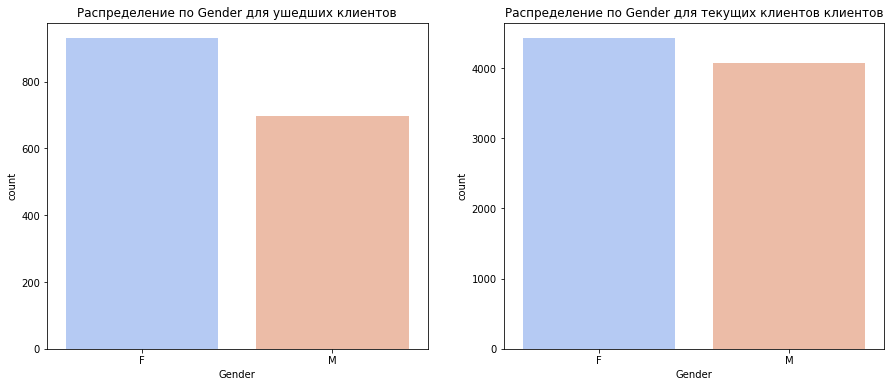

In [17]:
for column in ['Gender']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))
    sns.countplot(x=column, data=binary_features_1, ax=axes[0],palette='coolwarm')
    axes[0].set_title('Распределение по ' + column + ' для ушедших клиентов')
    sns.countplot(x=column, data=binary_features_0, ax=axes[1],palette='coolwarm')
    axes[1].set_title('Распределение по ' + column + ' для текущих клиентов клиентов')
    plt.show()

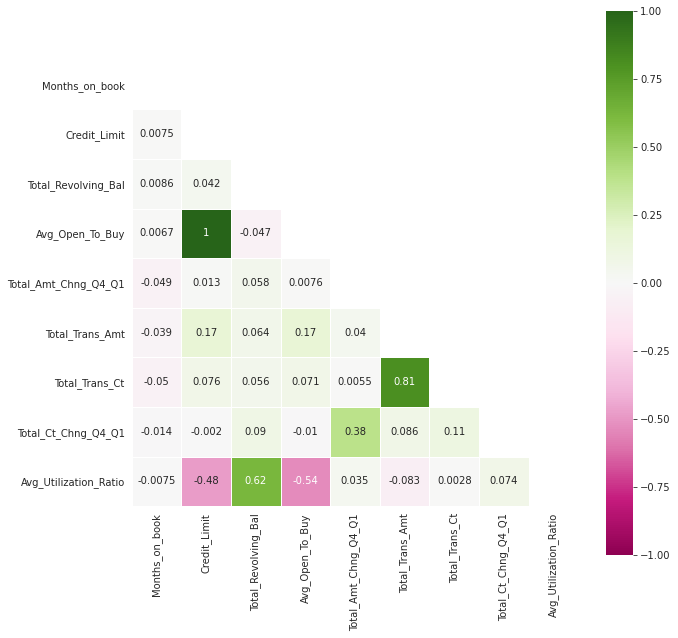

In [18]:
# Рассмотрим корреляцию признаков
corr = features_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, annot = True, mask=mask, vmax=1, vmin=-1,
                     center=0, square=True, linewidths=.5,cmap="PiYG")

## Подготовка данных для моделирования

In [19]:
#data[data.columns[1:]]

In [20]:
# Проведем OHE кодирование
#df_ohe = pd.get_dummies(data, drop_first=True)

In [21]:
#df_ohe.head()

In [22]:
# Разобьем выборку на трейн и тест с учетом баланса классов
X = data.drop('Attrition_Flag', axis=1)
y = data['Attrition_Flag']

# Избавимся от коррелирующих признаков
drop_columns = ['Avg_Open_To_Buy', 'Total_Trans_Ct']
X = X.drop(drop_columns, axis=1)

# Проведем OHE кодирование признаков
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=12345, stratify=y)
print("Баланс классов полного датасета:",len(y[y == 1])/len(y))
print("Баланс классов обучающего датасета:",len(y_train[y_train == 1])/len(y_train))
print("Баланс классов тестового датасета:",len(y_test[y_test == 1])/len(y_test))

Баланс классов полного датасета: 0.1606596227905599
Баланс классов обучающего датасета: 0.1606941309255079
Баланс классов тестового датасета: 0.16057913787430075


In [23]:
# Масштабируем числовые признаки, 
# обучим на обучающей выборке StandardScaler и применим его к обучающей и тестовой выборке
numeric_features = ['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
        'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Over-Sampling при помощи SMOTE
На высоком уровне SMOTE:
создаёт синтетические образцы на основе выборок минорного класса (не подписавшихся) вместо создания их копий;
случайно выбирает одного из ближайших k-соседей и использует его для создания схожих, но случайно изменённых новых сведений.

In [24]:
# Восстановим баланс классов алгоритмом SMOTE на обучающей выборке
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=12345)
os_X_train,os_y_train=os.fit_resample(X_train, y_train)

print("Баланс классов обучающего датасета после применения SMOTE:", len(os_y_train[os_y_train == 1])/len(os_y_train))

Баланс классов обучающего датасета после применения SMOTE: 0.5


In [25]:
len(y_train)

7088

In [26]:
roc_auc_list = []
fit_predict_time_list = []
f1_list = []
accuracy_list = []

In [27]:
def fit_predict_model(model, parameters,model_name):
    start = time.time()
    #fit
    cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=12345)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv)
    grid_model.fit(os_X_train, os_y_train)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    
    #predict
    pred_test = grid_model.best_estimator_.predict(X_test)
    pred_proba_test = grid_model.best_estimator_.predict_proba(X_test)[:, 1]
    stop = time.time()
    f1 = round(f1_score(y_test, pred_test), 4)
    accuracy = round(accuracy_score(y_test, pred_test), 4)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
    timer = int(stop) - int(start)
    fit_predict_time_list.append(timer)
    
    #roc_auc
    roc_auc = round(roc_auc_score(y_test, pred_proba_test),4)
    roc_auc_list.append(roc_auc)
    print("\nclassification_report:\n", classification_report(y_test, pred_test))
    print('ROC-AUC: ', roc_auc)
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.025])
    plt.xlim([-0.025, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая для {model_name}')
    plt.show()
    return grid_model.best_estimator_

In [28]:
def plot_feature_importance(model,names,model_type):
    importance = model.feature_importances_
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Logistic Regression

Лучшая оценка на валидации:  0.9311828581751583
Лучшие гиперпараметры модели на валидации:  {'C': 2.6323157894736844, 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая модель:  LogisticRegression(C=2.6323157894736844, n_jobs=-1, random_state=12345)

classification_report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      2551
           1       0.47      0.59      0.52       488

    accuracy                           0.83      3039
   macro avg       0.69      0.73      0.71      3039
weighted avg       0.85      0.83      0.83      3039

ROC-AUC:  0.8087


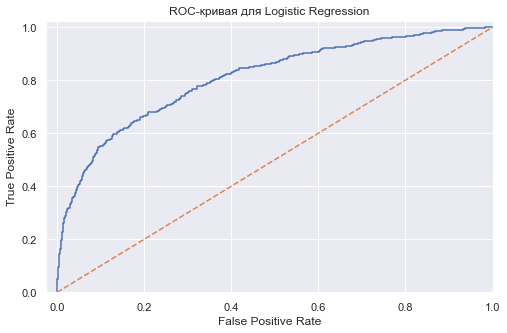

In [29]:
lr = LogisticRegression(random_state=12345, n_jobs=-1)
lr_param = {'C' : np.linspace(0.001, 10, 20, 50),
           'solver' : ['liblinear', 'lbfgs'],
           'penalty' : ['l1', 'l2']}
lr_itog = fit_predict_model(lr, lr_param, 'Logistic Regression')

In [30]:
#ранжирование и отбор признаков с помощью Recursive Feature Elimination

rfe = RFE(estimator=LogisticRegression())
model = LogisticRegression(C=2.1060526315789474, n_jobs=-1, random_state=12345, solver='lbfgs', penalty = 'l2')

pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])
pipe.fit(os_X_train, os_y_train)
rfe2 = pd.DataFrame(rfe.support_, index=os_X_train.columns, columns=['Rank'])
cols = rfe2.index
os_X_train3 = os_X_train[cols]

In [31]:
import statsmodels.api as sm
logit_model=sm.Logit(os_y_train,os_X_train3)
result=logit_model.fit()
print(result.summary2())
coef = pd.DataFrame(result.params, columns=['coef'])
coef['coef'] = abs(coef['coef'])
coef = coef.sort_values(by='coef', ascending=False)
print("\nНаиболее значимые параметры:\n", coef.head())
print("\nНаименее значимые параметры:\n", coef.tail())

Optimization terminated successfully.
         Current function value: 0.389705
         Iterations 7
                                Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.438    
Dependent Variable:      Attrition_Flag        AIC:                   9333.4097
Date:                    2021-12-07 18:00      BIC:                   9554.9334
No. Observations:        11898                 Log-Likelihood:        -4636.7  
Df Model:                29                    LL-Null:               -8247.1  
Df Residuals:            11868                 LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------

### RandomForest Classifier

Лучшая оценка на валидации:  0.9957877158980118
Лучшие гиперпараметры модели на валидации:  {'max_depth': 19, 'n_estimators': 170}
Лучшая модель:  RandomForestClassifier(max_depth=19, n_estimators=170, random_state=12345)

classification_report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      2551
           1       0.83      0.77      0.80       488

    accuracy                           0.94      3039
   macro avg       0.90      0.87      0.88      3039
weighted avg       0.94      0.94      0.94      3039

ROC-AUC:  0.9671


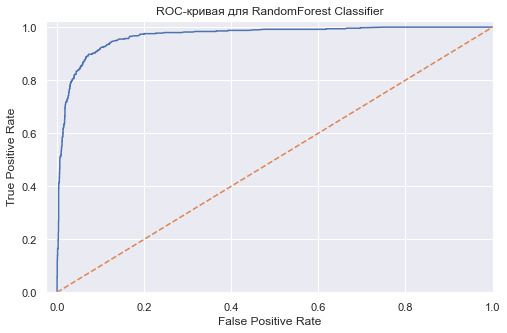

In [32]:
rf = RandomForestClassifier(random_state=12345)
rf_params = {'n_estimators' : range(10, 200, 20), 
             'max_depth' : range(1, 22, 3)}
rf_itog = fit_predict_model(rf, rf_params, 'RandomForest Classifier')

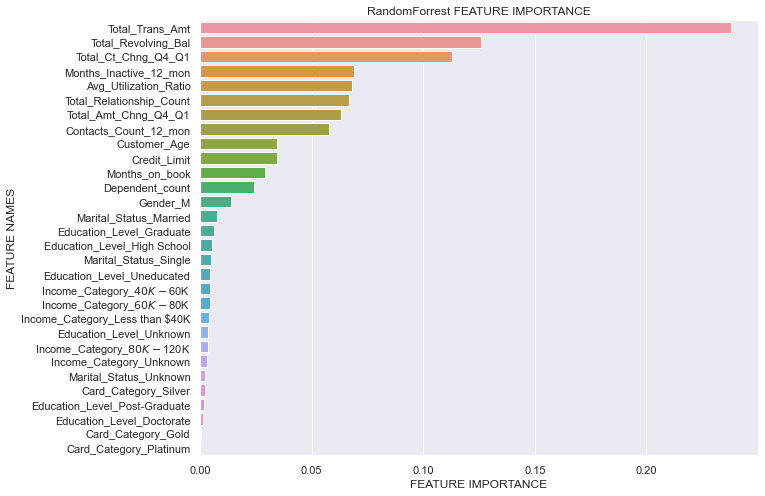

In [33]:
plot_feature_importance(rf_itog, X_train.columns,'RandomForrest')

### CatBoost Classifier

Лучшая оценка на валидации:  0.9977349240783525
Лучшие гиперпараметры модели на валидации:  {'depth': 8, 'iterations': 390, 'learning_rate': 0.1}
Лучшая модель:  <catboost.core.CatBoostClassifier object at 0x7fdd0c9d7b10>

classification_report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2551
           1       0.90      0.82      0.86       488

    accuracy                           0.96      3039
   macro avg       0.93      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

ROC-AUC:  0.9835


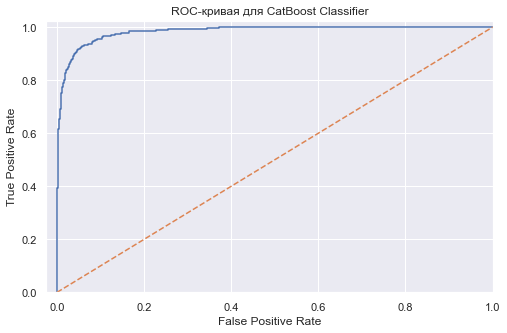

In [34]:
cat = CatBoostClassifier(verbose=False, random_state=12345)
cat_params = {'iterations' : range(150, 400, 30), 
              'depth' : range(2, 12, 2), 
              'learning_rate': [0.1, 0.01]}
cat_itog = fit_predict_model(cat, cat_params, 'CatBoost Classifier')

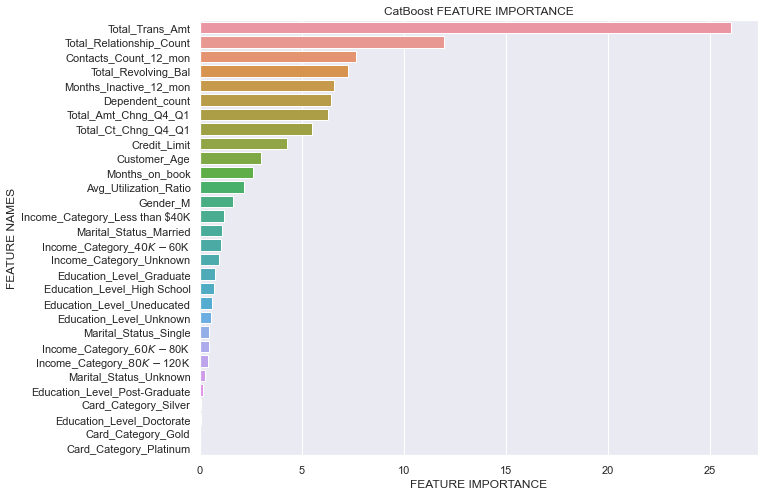

In [35]:
plot_feature_importance(cat_itog, X_train.columns,'CatBoost')

### LGBM Classifier

Лучшая оценка на валидации:  0.9981323053252863
Лучшие гиперпараметры модели на валидации:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 440}
Лучшая модель:  LGBMClassifier(max_depth=9, n_estimators=440, random_state=12345)

classification_report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2551
           1       0.89      0.83      0.86       488

    accuracy                           0.96      3039
   macro avg       0.93      0.91      0.92      3039
weighted avg       0.96      0.96      0.96      3039

ROC-AUC:  0.9845


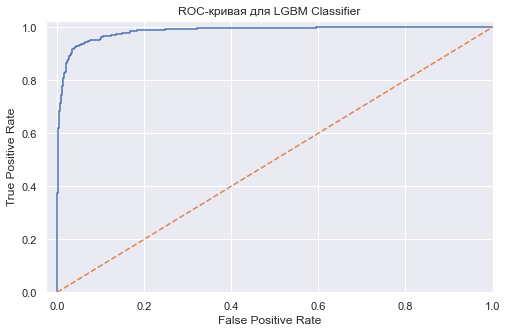

In [36]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=12345)
lgbm_param = {'n_estimators': range(350, 500, 30),
                  'max_depth': range(3, 12, 3),
             'learning_rate': [0.1, 0.01]}

lgbm_itog = fit_predict_model(lgbm, lgbm_param, 'LGBM Classifier')

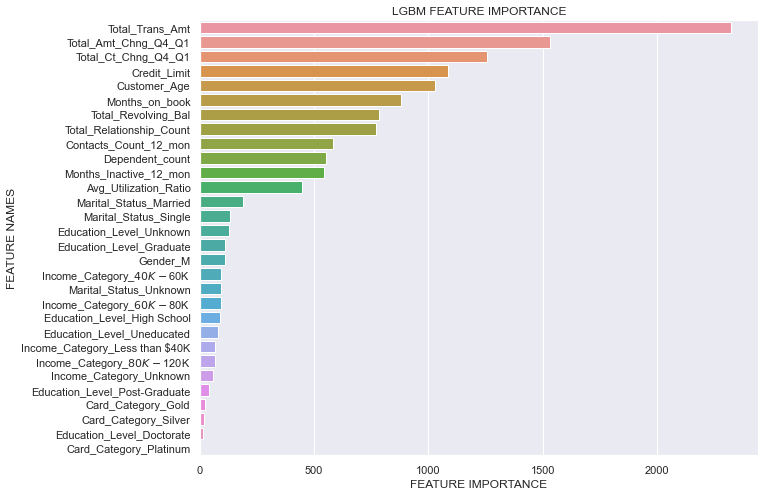

In [37]:
plot_feature_importance(lgbm_itog, X_train.columns, 'LGBM')

### XGBoost 

Лучшая оценка на валидации:  0.9978432671503507
Лучшие гиперпараметры модели на валидации:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 550}
Лучшая модель:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=550, n_jobs=8,
              num_parallel_tree=1, random_state=12345, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=12345, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

classification_report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2551
           1       0.89      0.85      0.87       488



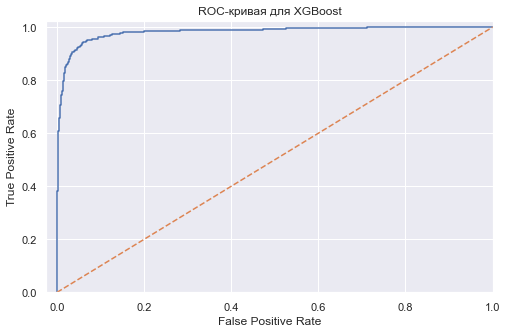

In [38]:
xgb = XGBClassifier(objective= 'binary:logistic',eval_metric = "logloss",seed=12345)
xgb_params = {
    'max_depth': range (5, 8, 1),
    'n_estimators': range(550, 650, 20),
    'learning_rate': [0.1, 0.01],
    'gamma': [0.1,0.01]
}
xgb_itog = fit_predict_model(xgb, xgb_params, 'XGBoost')

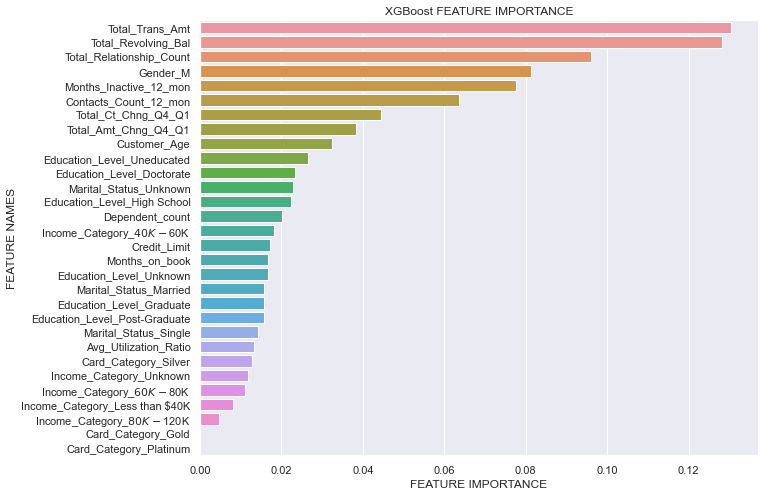

In [39]:
plot_feature_importance(xgb_itog, X_train.columns, 'XGBoost')

### Итоги


In [40]:
results = pd.DataFrame(data = [roc_auc_list, f1_list, fit_predict_time_list], 
                       index = ['ROC-AUC', 'F1-Score', 'Time_seconds'],
                      columns = ['Logistic Regression', 'RandomForrest', 'CatBoost', 'LGBM', 'XGBoost']).T
results['Time_seconds'] = results['Time_seconds'].astype('int')

In [41]:
results

,ROC-AUC,F1-Score,Time_seconds
Logistic Regression,0.8087,0.5226,49
RandomForrest,0.9671,0.8009,150
CatBoost,0.9835,0.8581,608
LGBM,0.9845,0.8611,36
XGBoost,0.9818,0.8695,737
